In [1]:
import os
import torch
import tqdm
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.models as models
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler

# import wandb
# Initialize a new run
# wandb.init(project='geo-life')

## **GeoLifeCLEF 2024**

Evan Turkon

#### [Kaggle Comp](https://www.kaggle.com/competitions/geolifeclef-2024/overview)

The challenge aims to predict plant species in a given location and time using various possible predictors: satellite images and time series, climatic time series, and other rasterized environmental data: land cover, human footprint, bioclimatic, and soil variables. To handle all the different data types a custom data class is created to get items based on the referance column in the metadata '**SurveyId**'.

<img src="Images/img.png" width="600" />

### **Data**
1. Observations Data (Labels):
   - Presence-Absence Data: Surveys of species presence and absence in different locations.
   - Presence-Only Data: Observations of species in various locations.

2. Environmental Data:
   - Spatialized geographic and environmental variables as additional input data.

3. Satellite Image Patches:
   - Includes RGB and NIR patches centered at the observation location, captured in the same year.

4. Satellite Time Series:
   - High-resolution, local signature of the past 20 years showing seasonal vegetation changes, extreme natural events (like fires), and land use changes.

5. Environmental Rasters:
   - GeoTIFF rasters and extracted scalar values, including:
     * Bioclimatic rasters
     * Soil rasters
     * Elevation maps
     * Land cover maps
     * Human footprint maps

### <u>Data Directories</u>

In [2]:
# Elevation Rasters
elevation_train = "data/EnvironmentalRasters/EnvironmentalRasters/Elevation/GLC24-PA-train-elevation.csv"
elevation_test = "data/EnvironmentalRasters/EnvironmentalRasters/Elevation/GLC24-PA-test-elevation.csv"
# Human Footprint Rasters
humanfootprint_train = "data/EnvironmentalRasters/EnvironmentalRasters/Human Footprint/GLC24-PA-train-human_footprint.csv"
humanfootprint_test = "data/EnvironmentalRasters/EnvironmentalRasters/Human Footprint/GLC24-PA-test-human_footprint.csv"
# Land Cover Rasters
landcover_train = "data/EnvironmentalRasters/EnvironmentalRasters/LandCover/GLC24-PA-train-landcover.csv"
landcover_test = "data/EnvironmentalRasters/EnvironmentalRasters/LandCover/GLC24-PA-test-landcover.csv"
# Soil Grid Rasters
soilgrids_train = "data/EnvironmentalRasters/EnvironmentalRasters/SoilGrids/GLC24-PA-train-soilgrids.csv"
soilgrids_test = "data/EnvironmentalRasters/EnvironmentalRasters/SoilGrids/GLC24-PA-test-soilgrids.csv"
# Sattelite Patches
train_patches_nir = "data/PA_Train_SatellitePatches_NIR/pa_train_patches_nir"
test_patches_nir = "data/PA_Test_SatellitePatches_NIR/pa_test_patches_nir"
train_patches_rgb = "data/PA_Train_SatellitePatches_RGB/pa_train_patches_rgb"
test_patches_rgb = "data/PA_Test_SatellitePatches_RGB/pa_test_patches_rgb"
# Time Series Cubes
tsc_bioclim_monthly_train = "data/TimeSeries-Cubes/TimeSeries-Cubes/GLC24-PA-train-bioclimatic_monthly/GLC24-PA-train-bioclimatic_monthly"
tsc_bioclim_monthly_test = "data/TimeSeries-Cubes/TimeSeries-Cubes/GLC24-PA-test-bioclimatic_monthly/GLC24-PA-test-bioclimatic_monthly"
tsc_landsat_monthly_train = "data/TimeSeries-Cubes/TimeSeries-Cubes/GLC24-PA-train-landsat_time_series/GLC24-PA-train-landsat-time-series"
tsc_landsat_monthly_test = "data/TimeSeries-Cubes/TimeSeries-Cubes/GLC24-PA-test-landsat_time_series/GLC24-PA-test-landsat_time_series"
# Meta Data
# meta_po_train = "data/GLC24_P0_metadata_train.csv"
meta_pa_train = "data/GLC24_PA_metadata_train.csv"
meta_pa_test = "data/GLC24_PA_metadata_test.csv"

In [3]:
# get gpu
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using apple metal GPU")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using nvidia GPU")
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU")

Using apple metal GPU


### <u>Data Class</u>

All data is loaded referenced by the primary key '**SurveyId**' in the `__get_item__` method. Knowing one '**SurveyId**' could have multiple associated '**SpeciesId**'s a dictionary is created to look up every unique associated '**SpeciesId**'. The `get_species_to_idx` method is used when converting the ouputs back to '**SpeciesId**' in testing.

In [4]:
class Data():
    def __init__(self, meta_data, elevation, humanfootprint, \
        landcover, soilgrids, sat_nir, sat_rgb, tsc_bioclim_monthly, \
        tsc_landsat_monthly, transform=None, training=True):
        # csvs
        self.meta_data = pd.read_csv(meta_data)
        self.elevation = self.read_and_scale(elevation, skip_columns=['surveyId'])
        self.humanfootprint = self.read_and_scale(humanfootprint, replace_inf=True, skip_columns=['surveyId'])
        self.landcover = self.read_and_scale(landcover, skip_columns=['surveyId'])
        self.soilgrids = self.read_and_scale(soilgrids, skip_columns=['surveyId'])

        # data dirs
        self.sat_nir = sat_nir
        self.sat_rgb = sat_rgb
        self.tsc_bioclim_monthly = tsc_bioclim_monthly
        self.tsc_landsat_monthly = tsc_landsat_monthly

        self.transform = transform
        self.training = training
        if self.training == True:
            self.species_to_idx = {}
            classes = sorted(self.meta_data['speciesId'].unique())
            for i, species in enumerate(classes):
                self.species_to_idx[species] = i
            unique_surveys = self.meta_data['surveyId'].unique()
            self.survey_to_species_dict = {}
            for survey in unique_surveys:
                unique_species = self.meta_data[self.meta_data['surveyId']==survey]['speciesId'].unique()
                indices = [self.species_to_idx[s] for s in unique_species]
                l = torch.zeros(len(self.species_to_idx))
                l[indices] = 1
                self.survey_to_species_dict[survey] = l

    def read_and_scale(self, file_path, replace_inf=False, skip_columns=None):
        data = pd.read_csv(file_path)
        if replace_inf:
            data.replace([np.inf, -np.inf], np.nan, inplace=True)
        if skip_columns:
            means = data.drop(columns=skip_columns).mean()
        else:
            means = data.mean()
        data.fillna(means, inplace=True)
        if skip_columns:
            columns_to_scale = data.columns.difference(skip_columns)
        else:
            columns_to_scale = data.columns
        scaler = StandardScaler()
        data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])
        return pd.DataFrame(data, columns=data.columns)

    def impute_tensor(self, data):
        row_impute_val = torch.nanmean(data, dim=1, keepdim=True)
        imputed = torch.where(torch.isnan(data), row_impute_val, data)
        return imputed

    def get_sat_path(self, survey_id, sat_dir):
        path = sat_dir
        for d in (str(survey_id)[-2:], str(survey_id)[-4:-2]):
            path = os.path.join(path, d)
        path = os.path.join(path, f"{str(survey_id)}.jpeg")
        return path

    def __getitem__(self, idx):
        # surveyId
        survey_id = self.meta_data['surveyId'][idx]

        # nir img
        nir_img_path = self.get_sat_path(survey_id, self.sat_nir)
        nir_img = Image.open(nir_img_path).convert("L")
        nir_img = self.transform(nir_img)

        # rgb img
        rgb_img_path = self.get_sat_path(survey_id, self.sat_rgb)
        rgb_img = Image.open(rgb_img_path).convert("RGB")
        rgb_img = self.transform(rgb_img)

        # time series cubes
        bioclim_tsc = torch.load(f"{self.tsc_bioclim_monthly}_{survey_id}_cube.pt")
        bioclim_tsc = self.impute_tensor(bioclim_tsc)
        landsat_tsc = torch.load(f"{self.tsc_landsat_monthly}_{survey_id}_cube.pt")
        landsat_means = torch.nanmean(landsat_tsc, dim=(-2, -1), keepdim=True)
        landsat_tsc = torch.where(torch.isnan(landsat_tsc), landsat_means, landsat_tsc)

        # raster
        elevation_val = self.elevation[self.elevation['surveyId']==survey_id]
        humanfootprint_vals = self.humanfootprint[self.humanfootprint['surveyId']==survey_id]
        landcover_val = self.landcover[self.landcover['surveyId']==survey_id]
        soildgrid_vals = self.soilgrids[self.soilgrids['surveyId']==survey_id]

        # lat, lon
        lat_lon = pd.Series([self.meta_data['lat'][idx], self.meta_data['lon'][idx]])

        # concat tabular data

        tab_data = pd.concat([elevation_val, humanfootprint_vals, landcover_val, soildgrid_vals, lat_lon])
        tensor_data = self.impute_tensor(torch.tensor(tab_data.to_numpy()))
        if self.training == True:
            species_ids = self.survey_to_species_dict[survey_id]
            return survey_id, nir_img, rgb_img, bioclim_tsc, landsat_tsc, tensor_data, species_ids
        return survey_id, nir_img, rgb_img, bioclim_tsc, landsat_tsc, tensor_data

    def __len__(self):
        return len(self.meta_data)

    def get_species_to_idx(self):
        if self.training == True:
            return self.species_to_idx

### <u>Test The Loader</u>

Create pytorch dataloaders using the Data class and preview the first occurance.

survey_id shape:  torch.Size([128]) 
nir_img:


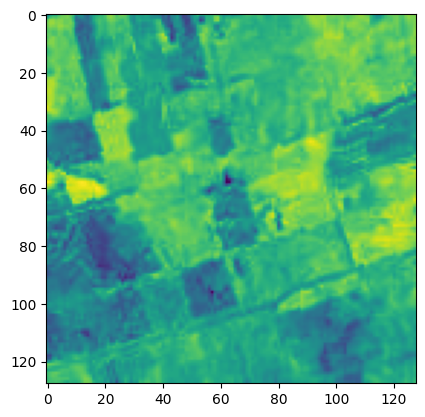

rgb_img:


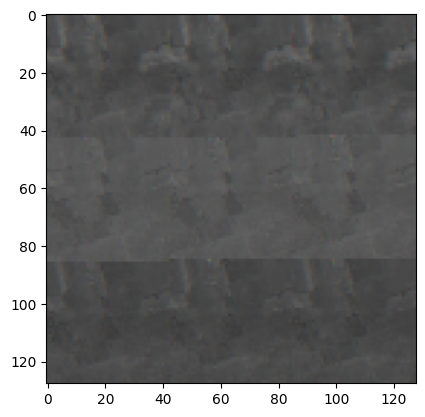

bioclim_tsc shape: torch.Size([128, 4, 19, 12]) 
landsat_tsc shape: torch.Size([128, 6, 4, 21]) 
tensor_data shape: torch.Size([128, 6, 29]) 
target shape: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [6]:
batch_size = 32*4
num_classes = 5016
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])
# data classes
train_data = Data(meta_pa_train, elevation_train, humanfootprint_train, landcover_train, \
    soilgrids_train, train_patches_nir, train_patches_rgb, tsc_bioclim_monthly_train, \
    tsc_landsat_monthly_train, transform)
test_data = Data(meta_pa_test, elevation_test, humanfootprint_test, landcover_test, \
    soilgrids_test, test_patches_nir, test_patches_rgb, tsc_bioclim_monthly_test, \
    tsc_landsat_monthly_test, transform, training=False)
# data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=0)
# test it
for survey_id, nir_img, rgb_img, bioclim_tsc, landsat_tsc, tensor_data, target in train_loader:

    print('survey_id shape: ', survey_id.shape, '\nnir_img:')
    nir_img = nir_img[0].numpy().reshape(128, 128, 1)
    plt.imshow(nir_img)
    plt.show()
    print('rgb_img:')
    rgb_img = rgb_img[0].numpy().reshape(128, 128, 3)
    plt.imshow(rgb_img)
    plt.show()
    print('bioclim_tsc shape:', bioclim_tsc.shape, '\nlandsat_tsc shape:', landsat_tsc.shape, '\ntensor_data shape:', tensor_data.shape, '\ntarget shape:', target)
    break

In [7]:
# kaggle metric
class SamplesAvgF1Loss(torch.nn.Module):
    def __init__(self):
        super(SamplesAvgF1Loss, self).__init__()

    def forward(self, preds, labels):
        preds, labels = preds.float(), labels.float()
        tp = (preds * labels).sum()
        fp = (preds * (1 - labels)).sum()
        fn = ((1 - preds) * labels).sum()
        stat = - (1 / len(preds)) * (tp / (tp + 0.5 * (fp + fn) + 1e-7))
        return stat

### <u>Custom UNet model to be implemented in the ensemble</u>

In [8]:
class UNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=1, final_output_size=768):
        super(UNet, self).__init__()
        # Downsampling
        self.down1 = self.conv_block(in_channels, 32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.down2 = self.conv_block(32, 64)
        self.pool2 = nn.MaxPool2d(2, 2)
        # Bottleneck
        self.bottleneck = self.conv_block(64, 128)
        # Upsampling
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv4 = self.conv_block(128, 64)
        self.up5 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.up_conv5 = self.conv_block(64, 32)
        # Output layer
        self.out_conv = nn.Conv2d(32, out_channels, kernel_size=1)
        # Determine the flat size dynamically after understanding the convolution output size
        self.dummy_param = nn.Parameter(torch.empty(0))  # used for inferring device and dtype
        self.fc = nn.Linear(2048, final_output_size)  # 2048 is a placeholder, will be computed dynamically

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Downsampling
        c1 = self.down1(x)
        p1 = self.pool1(c1)
        c2 = self.down2(p1)
        p2 = self.pool2(c2)
        # Bottleneck
        bottleneck = self.bottleneck(p2)
        # Upsampling
        u4 = self.up4(bottleneck)
        u4 = torch.cat([u4, c2], dim=1)
        c4 = self.up_conv4(u4)
        u5 = self.up5(c4)
        u5 = torch.cat([u5, c1], dim=1)
        c5 = self.up_conv5(u5)
        # Output layer
        outputs = self.out_conv(c5)
        outputs = outputs.view(outputs.size(0), -1)  # Flatten the output
        # Dynamically adjust the input size of the fully connected layer if necessary
        if self.fc.in_features != outputs.shape[1]:
            self.fc = nn.Linear(outputs.shape[1], 768).to(device=self.dummy_param.device, dtype=self.dummy_param.dtype)
        outputs = self.fc(outputs)
        return outputs

### <u>Full Model Architecture</u>
<img src="Images/arch.png" width="600" />

We included a diagram of the architecture above. It uses all the available data to come up with a prediction. Each data type is processed by a specific neural network model—UNet for NIR images, Swin Transformer for RGB images, and ResNet for the environmental and time series data. These models turn the complex input data into simpler, smaller data chunks known as embeddings (768 dimensions for images and 1000 dimensions for rasters and time series). The embeddings from all sources are then combined and passed through several layers (dense layers) to mix the features thoroughly. The final part of the system is a multi-label prediction layer, which can make several predictions at once, such as identifying different species or environmental attributes. This method is especially good for handling different kinds of data that change over time and space, using various neural network models to capture and combine the data's important features.

In [9]:
class MultimodalEnsemble(nn.Module):
    def __init__(self, num_classes):
        super(MultimodalEnsemble, self).__init__()
        
        self.landsat_norm = nn.LayerNorm([6,4,21])
        self.landsat_model = models.resnet18(weights=None)
        # modify the first convolutional layer to accept 6 channels instead of 3
        self.landsat_model.conv1 = nn.Conv2d(6, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.landsat_model.maxpool = nn.Identity()
        
        self.bioclim_norm = nn.LayerNorm([4,19,12])
        self.bioclim_model = models.resnet18(weights=None)
        # modify the first convolutional layer to accept 4 channels instead of 3
        self.bioclim_model.conv1 = nn.Conv2d(4, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bioclim_model.maxpool = nn.Identity()

        # hierarchical vision transformer for rgb images
        self.rgb_model = models.swin_t(weights="IMAGENET1K_V1")
        self.rgb_model.head = nn.Identity() # [1000, 1]
        self.nir_model = UNet(in_channels=1)

        # nn to blow up tabular data
        self.tab_l1 = nn.Linear(174, 250)
        self.tab_l2 = nn.Linear(250, 500)
        self.tab_norm = nn.LayerNorm(500)
        
        self.ln1 = nn.LayerNorm(1000)
        self.ln2 = nn.LayerNorm(1000)
        self.fc1 = nn.Linear(4036, 4096)
        self.fc2 = nn.Linear(4096, 2048)
        self.fc3 = nn.Linear(2048, 1024)
        self.fc4 = nn.Linear(1024, num_classes)
        
        self.dropout = nn.Dropout(p=0.1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, landsat, bioclim, rgb_img, nir_img, raster):
        landsat = self.landsat_norm(landsat)
        landsat = self.landsat_model(landsat)
        landsat = self.ln1(landsat) # [6,4,21]
        bioclim = self.bioclim_norm(bioclim)
        bioclim = self.bioclim_model(bioclim)
        bioclim = self.ln2(bioclim) # [4,19,12]
        raster = raster.view(raster.size(0), -1)
        raster = self.tab_l1(raster)
        raster = self.tab_l2(raster)
        raster = self.tab_norm(raster)
        rgb = self.rgb_model(rgb_img) # [3, 128, 128]
        nir = self.nir_model(nir_img)
        # add embeddings and tabular data to a linear layer
        everything = torch.cat((landsat, bioclim, rgb, nir, raster), dim=1)
        everything = self.fc1(everything) # [2768, 4096]
        everything = self.dropout(everything)
        everything = self.relu(everything)
        everything = self.fc2(everything)
        everything = self.dropout(everything)
        everything = self.relu(everything)
        everything = self.fc3(everything)
        everything = self.dropout(everything)
        everything = self.relu(everything)
        out = self.fc4(everything)
        return out


### <u>Training Loop</u>

The training process spans 10 epochs, utilizing an AdamW optimizer with a learning rate of 0.001 and a step-based learning rate scheduler. The loop iterates over batches of data comprising various modal inputs. Each batch processes these inputs through the model to predict species identities, calculating loss via cross-entropy and performing backpropagation. Additionally, top-10 prediction accuracy is tracked to assess model performance on a broader range of likely classes. Metrics such as loss and accuracy are printed periodically and after each epoch and saved to weights and biases for all group members to track training progress. The model state is saved after every epoch, and the scheduler adjusts the learning rate.

In [ ]:
model = MultimodalEnsemble(num_classes).to(device)

# hyperparameters
seed = 12
num_epochs = 10
learning_rate = 0.001
T_0 = 46364 // 4
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=2, eta_min=1e-6)
torch.manual_seed(seed)
np.random.seed(seed)
criterion = torch.nn.functional.binary_cross_entropy_with_logits

# survey_id, nir_img, rgb_img, bioclim_tsc, landsat_tsc, tensor_data, <target>
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (survey_id, nir_img, rgb_img, bioclim_tsc, landsat_tsc, raster, species_id) in enumerate(train_loader):
        rgb_img = rgb_img.to(device)
        nir_img = nir_img.to(device)
        species_id = species_id.to(device=device, dtype=torch.float)
        bioclim_tsc = bioclim_tsc.to(device)
        landsat_tsc = landsat_tsc.to(device)
        raster = raster.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(landsat_tsc, bioclim_tsc, rgb_img, nir_img, raster)
        loss = criterion(outputs, species_id)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        total += species_id.sum().sum()
        # use high cutoff, this accuracy will be very optimistic
        predicted = torch.where(outputs >= 0.9, 1, 0)
        correct += ((predicted == species_id) & (species_id == 1)).sum().item()
        if batch_idx % 278 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item()}")

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total * 100
    print(f"End of Epoch {epoch}, Loss: {epoch_loss:.4f}, Top-10 Accuracy: {epoch_accuracy:.2f}%")

    scheduler.step()
    print("Scheduler state:", scheduler.state_dict())
    model.eval()
    torch.save(model.state_dict(), "multimodal-model-pt1.pth")
    print("Model saved")
    # Log metrics to Weights and Biases
    # wandb.log({"Loss": f"{loss.item()}", "Top-10 Accuracy": f"{epoch_accuracy:.2f}%"})

### <u>Getting Predictions</u>

Foreward pass on testing data and converting the predictions back to '**SpeciesId**'s.

In [ ]:
with torch.no_grad():
    all_predictions = []
    surveys = []
    top_k_indices = None
    species_to_idx = train_data.get_species_to_idx()
    idx_to_species = {val: key for key, val in species_to_idx.items()} # invertn species_to_idx dict
    for batch_idx, (survey_id, nir_img, rgb_img, bioclim_tsc, landsat_tsc, raster) in enumerate(test_loader):
        rgb_img = rgb_img.to(device)
        nir_img = nir_img.to(device)
        species_id = species_id.to(device=device, dtype=torch.long)
        bioclim_tsc = bioclim_tsc.to(device)
        landsat_tsc = landsat_tsc.to(device)
        raster = raster.float().unsqueeze(1).to(device)
        outputs = model(landsat_tsc, bioclim_tsc, rgb_img, nir_img, raster)
        predictions = torch.sigmoid(outputs).cpu().numpy()

        # sellect top-25 values as predictions
        top_25 = np.argsort(-predictions, axis=1)[:, :25].tolist()
        top_25 = np.array([[idx_to_species[idx] for idx in top] for top in top_25])
        if top_k_indices is None:
            top_k_indices = top_25
        else:
            top_k_indices = np.concatenate((top_k_indices, top_25), axis=0)
        surveys.extend(survey_id.cpu().numpy())

data_concatenated = [' '.join(map(str, row)) for row in top_k_indices]

prediction_df = pd.DataFrame(
    {'surveyId': surveys,
     'predictions': data_concatenated,
    })

In [ ]:
prediction_df.to_csv("submission.csv", index = False)